#### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError

from extraction.extract import *
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency
# from extraction.adj_data import *

from sklearn.metrics import mean_absolute_error, mean_squared_error
%load_ext tensorboard
# %tensorboard --logdir logs/fit

##### Settings

These settings control the jupyter notebook. We have generated and stored 2 models, one for the top10 airports and one the top50. The default settings loads the model for the top 50 and displays the results. To try the top10 model, change airportsFull to ICAOTOP10 and runName to "top10MSE". To try a custom run, choose an airport list of your liking, change runName to something else, change saveModel to True, and loadModel to False. For reference, top10 took about 15 minutes to train and top50 about 45 minutes. 

Once your settings are set, you can just click run all in the jupyter interface. In the final plotting cell more settings can be changed.

In [2]:
airportsFull = ICAOTOP50
airports = airportsFull[::]
airports.remove("LTFM")  # removing the new istanbul airport as it opened mid-2019

n_nodes = n_airports = len(airports)
start = datetime(2018, 3, 1)
end = datetime(2019, 1, 1)
timeslotLength = 60

# Run settings
batch_size = 64
epochs = 1200
patience = 100
input_sequence_length = 4
forecast_horizon = 10
multi_horizon = True

learning_rate = 0.0001
# learning_rate = 0.0005
# learning_rate = 0.005

runName = "top50MSE"
saveModel = False
loadModel = True
modelSaveFolder = "kerasModels/"
modelSaveLocation = modelSaveFolder + runName


##### Load Data

In [3]:
dataDict = generateNNdataMultiple(
    airports, timeslotLength, GNNFormat=True, start=start, end=end, disableWeather=True
)
times = list(dataDict.values())[0]["T"]


100%|██████████| 49/49 [00:01<00:00, 26.17it/s]


##### Process Data

We reduce the amount of features and normalise the data

In [4]:
# we remove some of the most uncorrelated features
columnsToDrop = [
    "weekend",
    "winter",
    "spring",
    "summer",
    "autumn",
    "night",
    "morning",
    "afternoon",
    "planes",
]

Xlist = []
Ylist = []
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1).to_numpy()
    Xlist.append(X)

    Y = dataDict[airport]["Y"].iloc[:, :].to_numpy()
    Ylist.append(Y)


Xlist = np.stack(Xlist)
Ylist = np.stack(Ylist)
# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# Reshape to a flat array that goes arrival then departure delay
# Yarray = np.reshape(Yarray, newshape=[len(times), len(airports)*2], order="F")

# T x N x F

# Normalise over the features
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
X = (X - Xmean) / Xstd
print("X Mean Shape", Xmean.shape)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)
Y = (Y - Ymean) / Ystd
print("Y Mean Shape", Ymean.shape)

print("T x N x F: ", "Xarray =", Xarray.shape, "|", "Yarray =", Yarray.shape)


X Mean Shape (8,)
Y Mean Shape (2,)
T x N x F:  Xarray = (2928, 49, 8) | Yarray = (2928, 49, 2)


Here we make the raw data splits

In [5]:
train_split, val_split = 0.6, 0.25

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(
    f"Train split: {0}:{train_idx} | Validation split: {train_idx}:{val_idx} | Test split: {val_idx}:{fullLength}"
)

# generate raw splits
Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]

# Save test timeslots for plotting purposes
testTimes = times.iloc[val_idx::, 0].tolist()


Train split: 0:1756 | Validation split: 1756:2488 | Test split: 2488:2928


##### Create tensorflow dataset

Create a tensorflow dataset that handles lookback, lookforward and multi-horizon properties. Retrieved from a keras example and modified: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [6]:
def create_tf_dataset(
    data_array: np.ndarray,
    target_array,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = inputs
    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset = create_tf_dataset(
    Xtrain,
    Ytrain,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

val_dataset = create_tf_dataset(
    Xval,
    Yval,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)
test_dataset = create_tf_dataset(
    Xtest,
    Ytest,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

print(train_dataset)


<CacheDataset shapes: ((None, None, 49, 8), (None, None, 49, 2)), types: (tf.float64, tf.float64)>


# Adjacency Matrix

It was our original intent to use dynamic graphs for our st-gnn, however due to lack of time we kept it as a weighted average of the distance based distance_weight_adjacency() and an average of the adjancy matrices based on flights getAdjacencyMatrix().

In [7]:
distance_adj = distance_weight_adjacency(airports, threshold=400)
# unfortunately we only work with static graphs for now
# We take the average of all the dynamic adjacencies from the function above (stored for brevity)
flight_adj = np.mean(getAdjacencyMatrix(airports, start, end, timeslotLength), axis=0)

# print(flight_adj)

# flight_adj = flight_adj_avg

adjacency_matrix = distance_adj * 0.4 + (1 - 0.4) * flight_adj

node_indices, neighbor_indices = np.where(adjacency_matrix != 0)

graph_edges = (node_indices.tolist(), neighbor_indices.tolist())
graph_num_nodes = adjacency_matrix.shape[0]

print(flight_adj.shape)
# print(graph_edges)
print(graph_num_nodes)


(49, 49)
49


This block shows a heatmap of the adjacency matrix

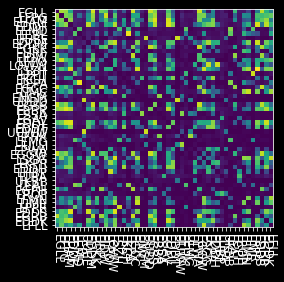

In [8]:
plt.imshow(adjacency_matrix)
plt.xticks(range(len(airports)), airports, fontsize=12, rotation=-90)
plt.yticks(range(len(airports)), airports, fontsize=12, rotation=0)
plt.show()


## Graph Convolution Layer

This is our GCN layer. Retrieved from a keras example and modified: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [9]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        # graph_info: GraphInfo,
        graph_num_nodes=graph_num_nodes,
        graph_edges: tuple = graph_edges,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat

        self.graph_edges = graph_edges
        self.graph_num_nodes = graph_num_nodes

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_edges[0],
                num_segments=self.graph_num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


## LSTM including graph convolution layer

This is our complete model, it is based off a road-traffic example that predicts all features for the next step. We modified it heavily to allow for predictions of 2 labels and multihorizon predictions. Retrieved from a keras example and modified: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [10]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        graph_edges: tuple,
        graph_num_nodes: int,
        graph_conv_params: typing.Optional[dict] = None,
        num_labels: int = 2,
        multi_horizon: int = True,
        forecast_horizon: int = forecast_horizon,
        **kwargs,
    ):

        if multi_horizon:
            self.forecast_horizon = forecast_horizon
        else:
            self.forecast_horizon = 1

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.lstm_units = lstm_units
        self.input_seq_len = input_seq_len
        self.graph_edges = (graph_edges,)
        self.graph_num_nodes = (graph_num_nodes,)

        self.graph_conv_params = graph_conv_params
        self.multi_horizon = multi_horizon
        self.num_labels = num_labels
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }

        # Layer definitions
        self.graph_conv = GraphConv(in_feat, out_feat, **graph_conv_params)
        # self.graph_conv2 = GraphConv(in_feat, out_feat, self.graph_edges, self.graph_num_nodes, **graph_conv_params)
        l2_reg = 2.5e-4  # L2 regularization rate

        self.lstm1 = layers.LSTM(
            lstm_units,
            return_sequences=True,
            activation="tanh",
            dropout=0.2,
            kernel_regularizer=l2(l2_reg),
            activity_regularizer=l2(l2_reg),
            bias_regularizer=l2(l2_reg),
        )
        self.lstm2 = layers.LSTM(
            lstm_units,
            activation="tanh",
            dropout=0.2,
            kernel_regularizer=l2(l2_reg),
            activity_regularizer=l2(l2_reg),
            bias_regularizer=l2(l2_reg),
        )
        # self.dense = layers.Dense(output_seq_len)
        self.denseThick = layers.Dense(128)
        self.denseThick2 = layers.Dense(64)
        self.denseThick3 = layers.Dense(16)
        self.dense = layers.Dense(self.forecast_horizon * self.num_labels)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "in_feat": self.in_feat,
                "out_feat": self.out_feat,
                "lstm_units": self.lstm_units,
                "input_seq_len": self.input_seq_len,
                "graph_conv_params": self.graph_conv_params,
                "graph_edges": self.graph_edges,
            }
        )
        return config

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])
        gcn_out = self.graph_conv(inputs)

        # print(f"The GCN output shape  = {gcn_out}")
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )
        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        # print(f"The input shape for the LSTM is {gcn_out}")
        lstmLayer1 = self.lstm1(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        lstmLayer2 = self.lstm2(lstmLayer1)
        dense_1 = self.denseThick(lstmLayer2)
        dense_2 = self.denseThick2(dense_1)
        dense_3 = self.denseThick3(dense_2)

        dense_output = self.dense(dense_3)
        # dense_output has shape: (batch_size * num_nodes, multi_thing*2)

        output = tf.reshape(
            dense_output,
            (num_nodes, batch_size, self.forecast_horizon, self.num_labels),
        )
        final = tf.transpose(output, [1, 2, 0, 3])
        return final
        # # returns Tensor of shape (batch_size, forecast_horizon, num_nodes, nlabels)


## Compiling the model

In [11]:
in_feat = Xarray.shape[2]

out_feat = 15
lstm_units = 128
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat=in_feat,
    out_feat=out_feat,
    lstm_units=lstm_units,
    input_seq_len=input_sequence_length,
    graph_edges=graph_edges,
    graph_num_nodes=graph_num_nodes,
    graph_conv_params=graph_conv_params,
    num_labels=2,
    multi_horizon=multi_horizon,
    forecast_horizon=forecast_horizon,
)


inputs = layers.Input((input_sequence_length, graph_num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)

optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 49, 8)]        0         
                                                                 
 lstmgc (LSTMGC)             (None, 10, 49, 2)         239260    
                                                                 
Total params: 239,260
Trainable params: 239,260
Non-trainable params: 0
_________________________________________________________________


## Training the model

Training the model, if loading the model from a previous run was not requestd. Using tensorboard, training can be followed live.

In [12]:
if not loadModel:
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, histogram_freq=1
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=patience),
            tensorboard_callback,
        ],
    )


### Save model

In [13]:
if saveModel and not loadModel:
    model.save(modelSaveLocation)
elif saveModel and loadModel:
    raise Exception(
        "You have enabled both loading and saving, which are incompatible. Model has not been saved"
    )


In [14]:
if not loadModel:
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()


#### Load model

In [15]:
if loadModel:
    model = keras.models.load_model(modelSaveLocation)
    model.summary()
else:
    model = model


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 49, 8)]        0         
                                                                 
 lstmgc_1 (LSTMGC)           (None, 10, 49, 2)         239260    
                                                                 
Total params: 239,260
Trainable params: 239,260
Non-trainable params: 0
_________________________________________________________________


## Analize model performance on the test data

This part of the notebook gives the performance per forecast horizon in the first plot. In the second plot, the predicted airport delay over time is compared to the real delay over time to illustrate the accuracy of the model. The default setting displays a window of 100 hours. As the model has a multi-horizon feature, you can choose for how many hours into the future to predict. The model is trained to predict between 1 and 10 hours into the future. You can choose to display a bigger window with the windowSize feature and how many hours ahead predicted should be illustrated.

In [16]:
windowSize = 100 # 1-400
hour = 10 # 1-10
hour = min(hour, forecast_horizon)
print(f"Hours ahead = {hour}")


Hours ahead = 10


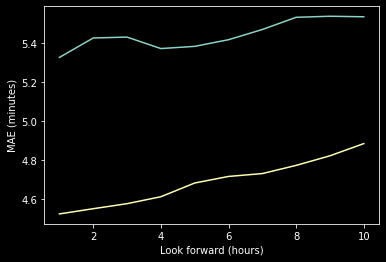

C:\Users\Trez\AppData\Local\Temp/ipykernel_17772/1637768575.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)


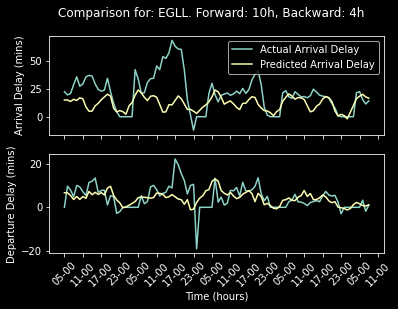

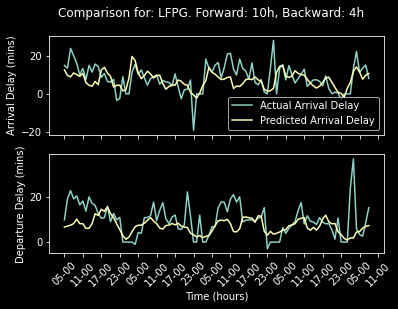

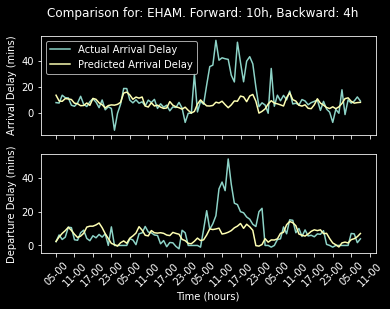

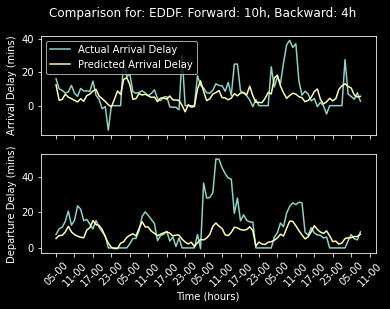

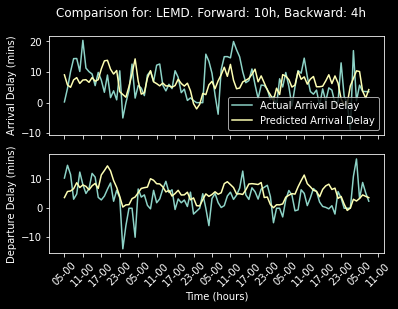

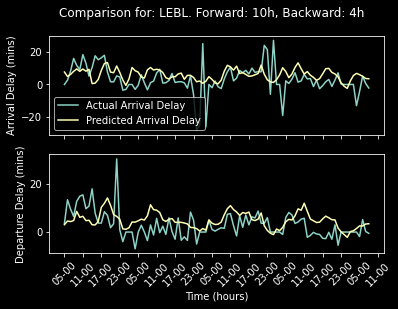

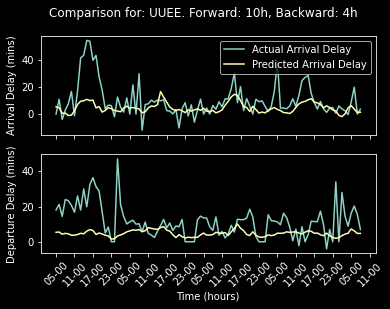

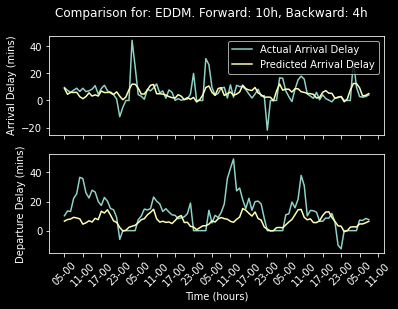

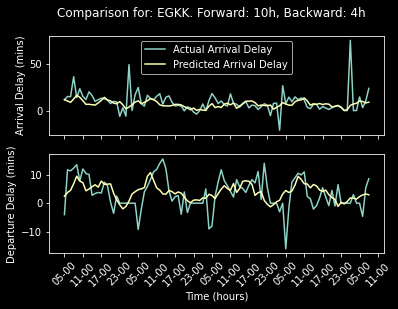

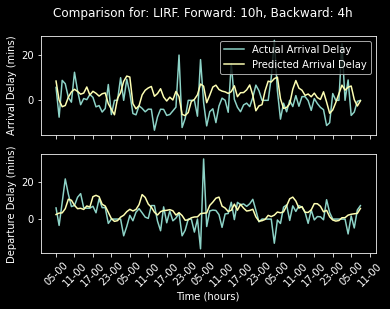

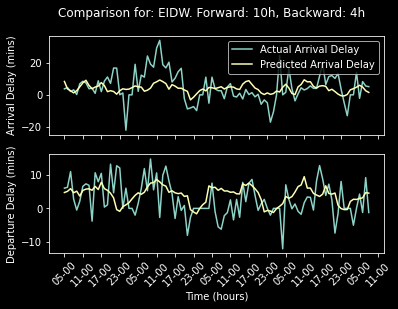

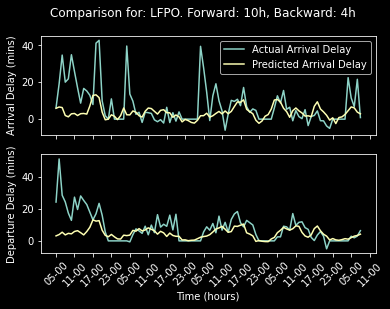

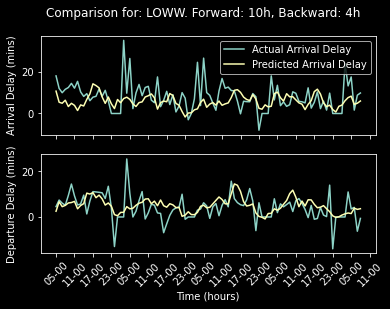

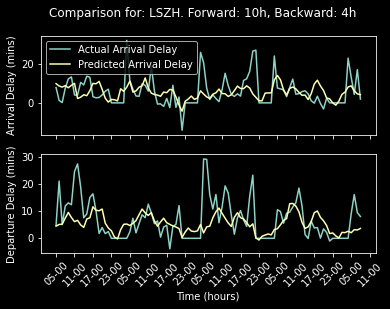

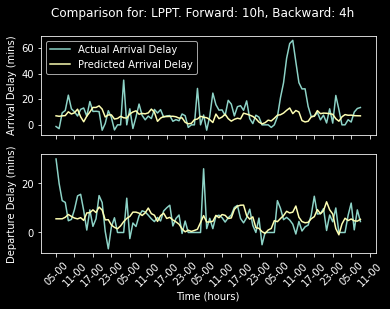

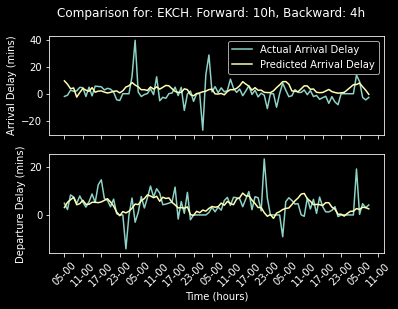

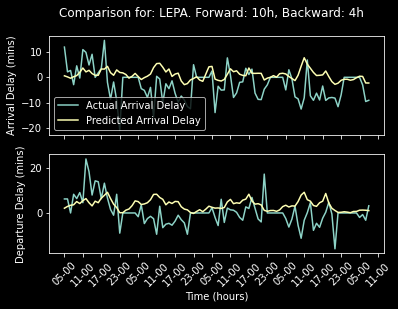

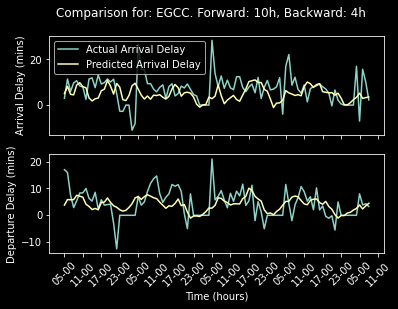

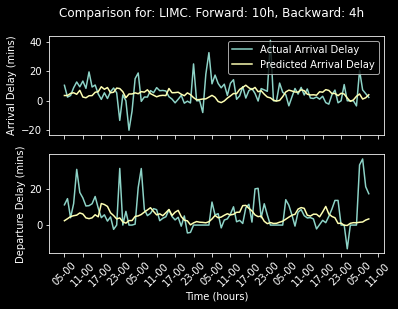

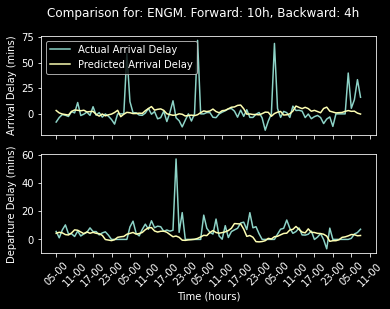

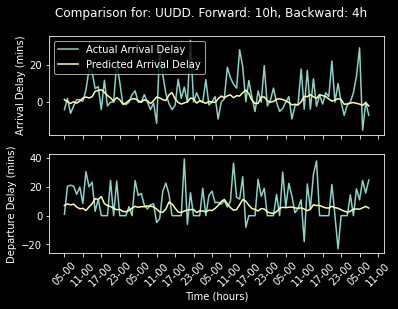

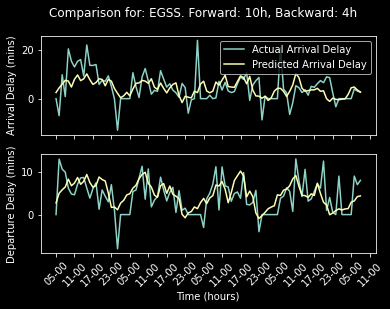

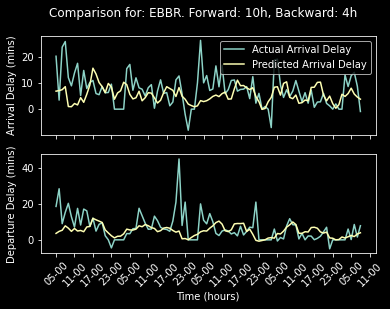

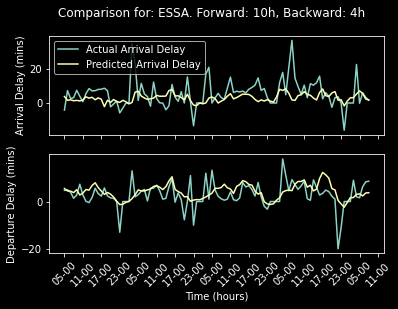

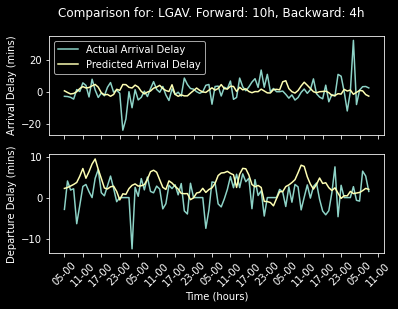

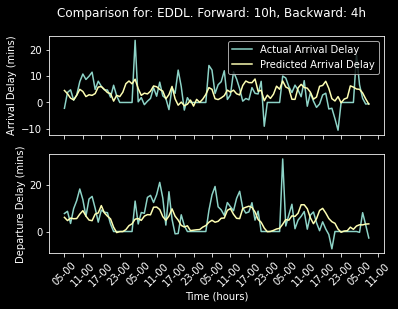

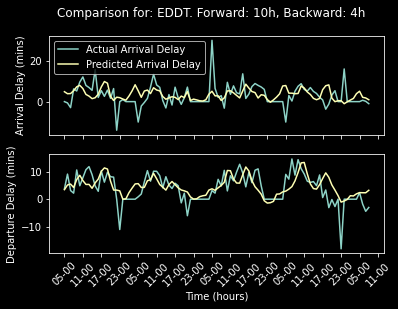

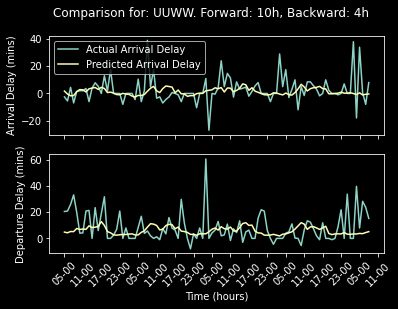

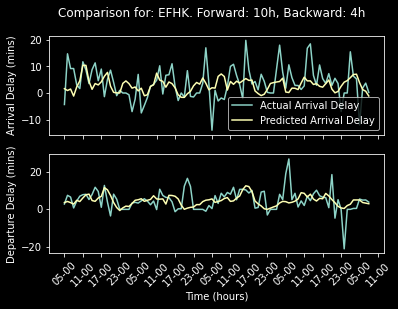

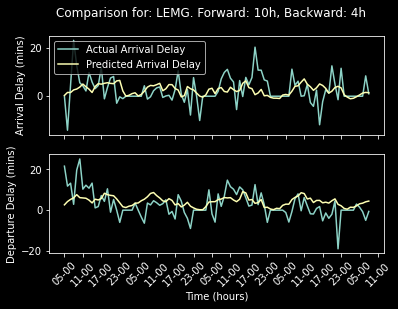

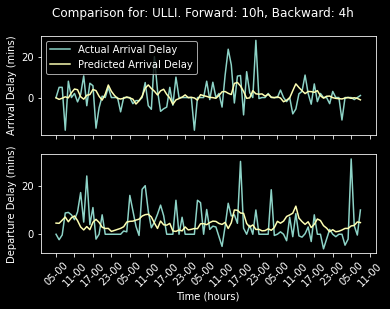

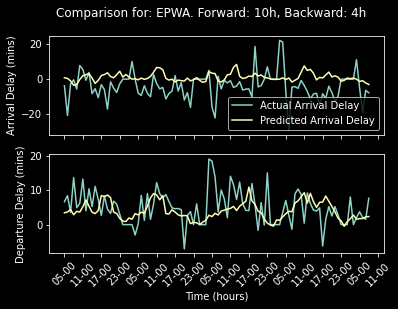

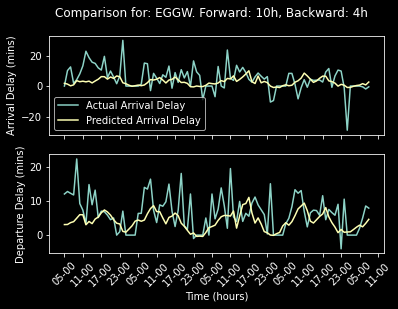

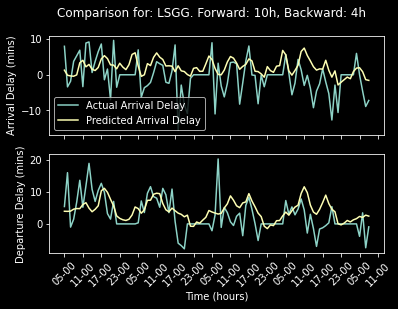

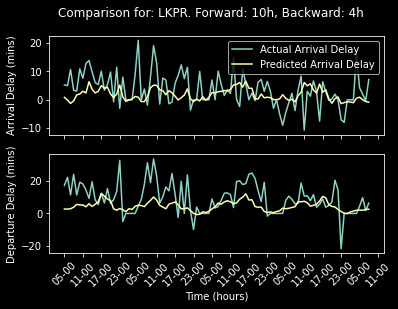

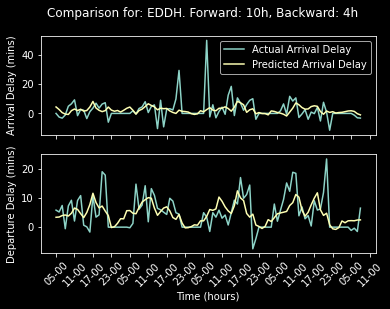

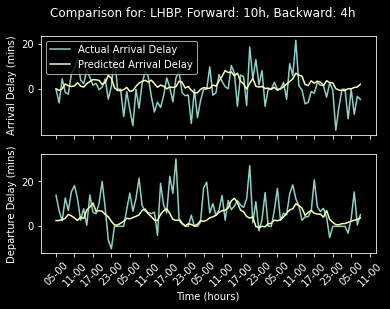

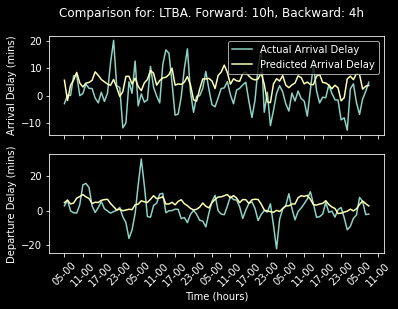

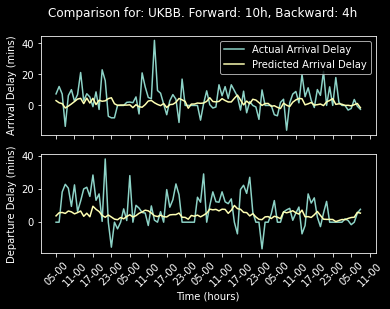

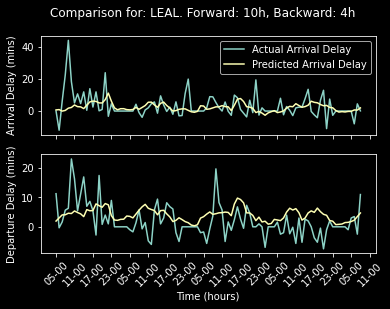

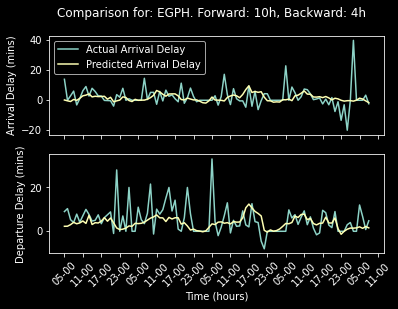

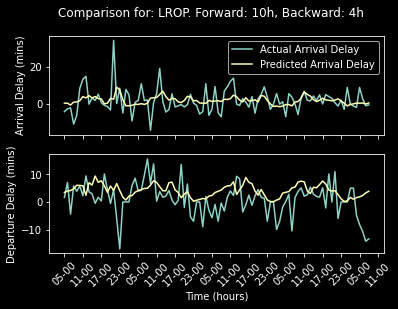

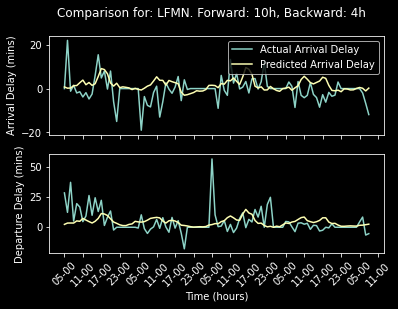

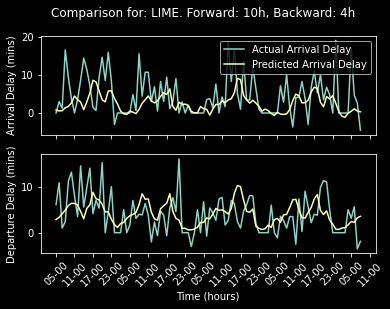

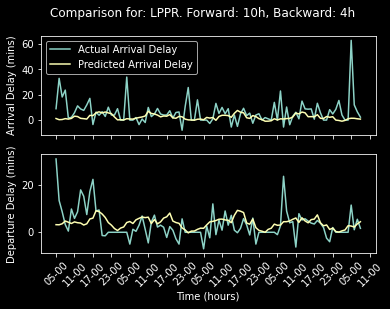

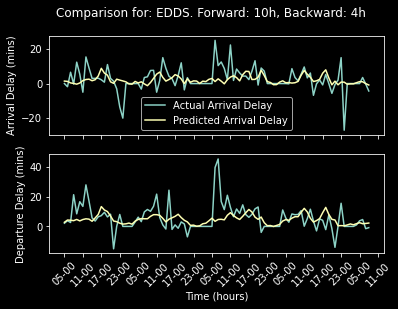

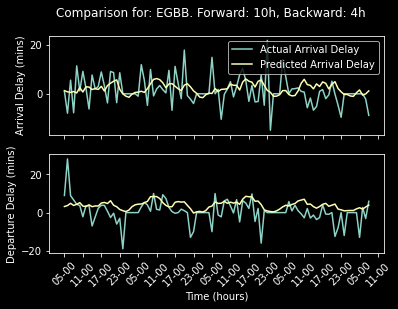

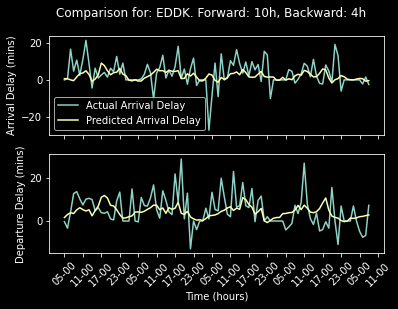

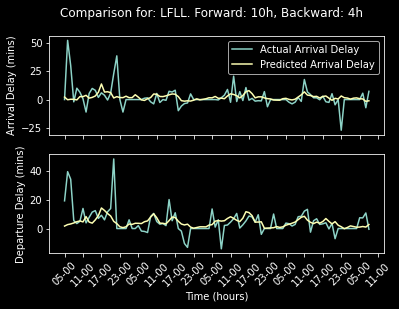

In [17]:
def getLabelArrays(hour, input_sequence_length=input_sequence_length):
    syncindex = input_sequence_length + hour - 1
    yTestPred = model.predict(test_dataset, verbose=0)
    ypredFull = yTestPred[:windowSize, hour - 1, :, :]
    yactualFull = Ytest[syncindex : windowSize + syncindex :, :]

    mae1 = mean_absolute_error(ypredFull[:, :, 0], yactualFull[:, :, 0])
    mae2 = mean_absolute_error(ypredFull[:, :, 1], yactualFull[:, :, 1])

    time = testTimes[syncindex : windowSize + syncindex :]
    return ypredFull, yactualFull, mae1, mae2, time


def plotComparison(airport_index, hour):
    ypredFull, yactualFull, _, _, time = getLabelArrays(hour)
    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(
        time, yactualFull[:, 0 + airport_index, 0], label="Actual Arrival Delay"
    )
    axs[1].plot(time, yactualFull[:, airport_index, 1], label="Actual Departure Delay")
    axs[0].plot(
        time, ypredFull[:, 0 + airport_index, 0], label="Predicted Arrival Delay"
    )
    axs[1].plot(time, ypredFull[:, airport_index, 1], label="Predicted Departure Delay")
    axs[0].legend()
    # axs[1].legend()
    axs[1].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Arrival Delay (mins)")
    axs[1].set_ylabel("Departure Delay (mins)")
    plt.suptitle(
        f"Comparison for: {airports[airport_index]}. Forward: {hour}h, Backward: {input_sequence_length}h"
    )
    axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
    plt.xticks(rotation=45)


def plotMAEOverTime(forecast_horizon=forecast_horizon):
    hours = list(range(1, forecast_horizon + 1))
    maeList = []
    maeList2 = []
    for h in hours:
        _, _, mae1, mae2, _ = getLabelArrays(h)
        maeList.append(mae1)
        maeList2.append(mae2)
    plt.plot(hours, maeList)
    plt.plot(hours, maeList2)
    plt.xlabel("Look forward (hours)")
    plt.ylabel("MAE (minutes)")


plotMAEOverTime()
plt.show()

for airportidx in range(0, len(airports)):
    plotComparison(airportidx, hour)
# plt.show()


## Generate data for Kepler gl visualization
If wanted, the data and predictions can be converted to the right format for use with kepler.gl. Kepler is the visualisation tool used for our report cover and in our presentation

In [18]:
syncindex = input_sequence_length + hour - 1
yTestPred = model.predict(test_dataset, verbose=0)
ypredFull = yTestPred[:, hour - 1, :, :]
timeKepler = testTimes[syncindex::]
Ykepler = Ytest[syncindex:, :]
generateKeplerData(
    airports=airports,
    start=timeKepler[0],
    end=end,
    timeslotLength=timeslotLength,
    predictions=ypredFull,
    actual=Ykepler,
)


100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


,Timeslot,Total # Departing flights,Total # Arriving flights,# Traditional flights,# Lowcost flights,airport,Arrival delay,Departure delay,Error,ADEP,ADEPLat,ADEPLong,ADES,ADESLat,ADESLong
0,2018-12-14 05:00:00,0,0,0,0,EGLL,14.9,6.6,7,UUEE,55.97250,37.41306,EGLL,51.47750,-0.46139
1,2018-12-14 06:00:00,21,2,22,1,EGLL,14.9,6.6,4,EDDF,50.03333,8.57056,EGLL,51.47750,-0.46139
2,2018-12-14 06:00:00,21,2,22,1,EGLL,14.9,6.6,4,LEMD,40.47222,-3.56083,EGLL,51.47750,-0.46139
3,2018-12-14 06:00:00,21,2,22,1,EGLL,14.9,6.6,4,LSZH,47.45806,8.54806,EGLL,51.47750,-0.46139
4,2018-12-14 06:00:00,21,2,22,1,EGLL,14.9,6.6,4,EFHK,60.31722,24.96333,EGLL,51.47750,-0.46139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25804,2018-12-31 19:00:00,0,1,0,1,LFLL,0.3,2.0,7,NaN,NaN,NaN,NaN,45.72556,5.08111
25805,2018-12-31 20:00:00,1,5,3,3,LFLL,-1.3,1.2,8,NaN,NaN,NaN,NaN,45.72556,5.08111
25806,2018-12-31 21:00:00,0,5,3,2,LFLL,-2.8,0.3,17,NaN,NaN,NaN,NaN,45.72556,5.08111
25807,2018-12-31 22:00:00,0,1,1,0,LFLL,-3.0,-0.6,5,NaN,NaN,NaN,NaN,45.72556,5.08111


## Add logbook to tensorboard
If wanted, the training logbook can be saved to Tensorboard.dev

In [19]:
# !tensorboard dev upload --logdir ./logs \
#   --name "Tuning model 2" \
#   --description "Trying some stuff ans last run on TOP50"\
#   --one_shot
